HELLO FOLKS AND WELCOME TO THIS NOTEBOOK  !

We will be working on a solution to the ISIC challenge 2024. We have to create an algorithm capable of identifying skin cancer
using images obtained from 3D TB SCAN

The images are already cropped and saved in .jpg format. We also have a csv with metadata that could be useful to complete our task. Keep in mind that the deadline is September 6th

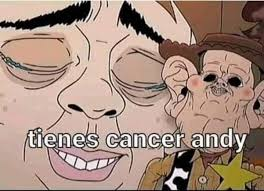

For more info, please feel free to go to the oficial page of the challenge in kaggle: https://www.kaggle.com/competitions/isic-2024-challenge/overview

# EDA

In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, Model

ModuleNotFoundError: No module named 'seaborn'

In [26]:
pd.set_option('display.max_columns', None)
data= pd.read_csv(r'C:\Users\migue\github_repository\isic-2024-challenge\train-metadata.csv')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\migue\\github_repository\\isic-2024-challenge\\train-metadata.csv'

<Figure size 1000x600 with 0 Axes>

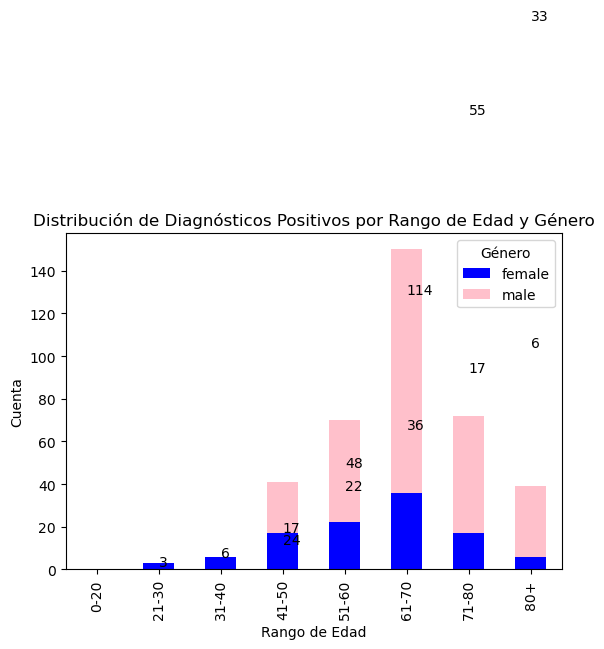

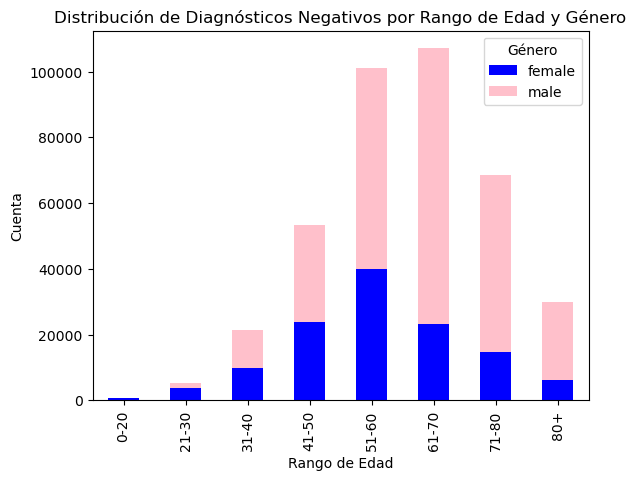

In [4]:
# Crear rangos de edad
bins = [0, 20, 30, 40, 50, 60, 70, 80, np.inf]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']
data['Rango_Edad'] = pd.cut(data['age_approx'], bins=bins, labels=labels, right=False)

# Separar por diagnóstico
data_positivo = data[data['target'] == 1]
data_negativo = data[data['target'] == 0]

# Contar los valores por rango de edad y género para cada diagnóstico
positivos_counts = data_positivo.groupby(['Rango_Edad', 'sex']).size().unstack(fill_value=0)
negativos_counts = data_negativo.groupby(['Rango_Edad', 'sex']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))

# Graficar barras apiladas para diagnósticos positivos
positivos_counts.plot(kind='bar', stacked=True, color=['blue', 'pink'])
plt.title('Distribución de Diagnósticos Positivos por Rango de Edad y Género')
plt.xlabel('Rango de Edad')
plt.ylabel('Cuenta')
plt.legend(title='Género')
plt.subplots_adjust(bottom=0.15, top=0.85)
# Añadir etiquetas encima de las barras
for i in range(len(positivos_counts)):
    for j, value in enumerate(positivos_counts.iloc[i]):
        if value > 0:
            plt.text(i, positivos_counts.iloc[:i + 1, j].sum() - value / 2, str(value), ha='left', color='black')

plt.show()

# Graficar barras apiladas para diagnósticos negativos
negativos_counts.plot(kind='bar', stacked=True, color=['blue', 'pink'])
plt.title('Distribución de Diagnósticos Negativos por Rango de Edad y Género')
plt.xlabel('Rango de Edad')
plt.ylabel('Cuenta')
plt.legend(title='Género')


plt.show()

Text(0.5, 1.0, 'Distribución del genero en casos positivos')

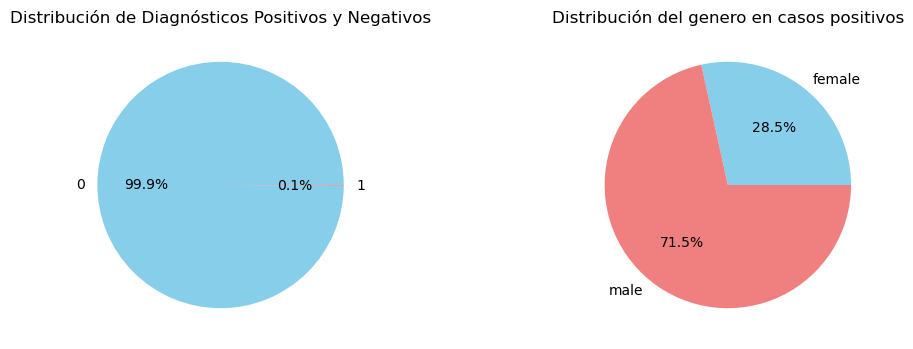

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
data['target'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribución de Diagnósticos Positivos y Negativos')
plt.ylabel('')  # Eliminar etiqueta del eje y
#plt.show()
plt.subplot(1, 2, 2)
genero = data_positivo.groupby(['sex']).size()
genero.plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribución del genero en casos positivos')

Here again we will have to handle class imbalance

# DATA WRANGLING

In [ ]:
data['target'].unique()

array([0, 1], dtype=int64)

In [ ]:
minority_images = data_positivo['isic_id'].tolist()

image_folder = r'C:\Users\migue\github_repository\isic-2024-challenge\train-image\image'

# Inicializar una lista para almacenar las imágenes cargadas
images = []

# Cargar y preprocesar cada imagen
for image_name in minority_images:
    image_path = os.path.join(image_folder, image_name + '.jpg')
    img = load_img(image_path, target_size=(139, 139))  # Cargar la imagen y redimensionar
    img_array = img_to_array(img)  # Convertir la imagen a array numpy
    images.append(img_array)

# Convertir la lista de imágenes a un array numpy
X_minoritaria = np.array(images)

# Normalizar las imágenes para que los valores estén entre 0 y 1
X_minoritaria = X_minoritaria.astype('float32') / 255.0

print(f"Se han cargado {X_minoritaria.shape[0]} imágenes de la clase minoritaria.")

Se han cargado 393 imágenes de la clase minoritaria.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Definir la dimensión latente
latent_dim = 16

# Encoder
input_img = layers.Input(shape=(139, 139, 3))  # Imágenes de 139x139 con 3 canales (RGB)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Ahora 70x70
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Ahora 35x35
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Ahora 18x18
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Reparametrización
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(18 * 18 * 128, activation='relu')(decoder_input)  # Regreso a 18x18
x = layers.Reshape((18, 18, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # Ahora 36x36
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # Ahora 72x72
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # Ahora 144x144
x = layers.Cropping2D(((2, 3), (2, 3)))(x)  # Recorta para regresar a 139x139
decoded_img = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)  # 3 canales para RGB

# Modelos
encoder = Model(input_img, [z_mean, z_log_var, z], name="encoder")
decoder = Model(decoder_input, decoded_img, name="decoder")

# Modelo VAE
output_img = decoder(encoder(input_img)[2])
vae = Model(input_img, output_img, name="vae")

# Función de pérdida
reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(input_img, output_img))
reconstruction_loss *= 139 * 139 * 3  # Ajuste para imágenes RGB (3 canales)
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss *= -0.5
vae_loss = reconstruction_loss + kl_loss

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Entrenar el VAE con los datos de la clase minoritaria
vae.fit(X_minoritaria, X_minoritaria, epochs=50, batch_size=32, shuffle=True)


Epoch 1/50
13/13 [==============================] - 31s 1s/step - loss: 39071.0508
Epoch 2/50
13/13 [==============================] - 12s 954ms/step - loss: 38821.5000
Epoch 3/50
13/13 [==============================] - 12s 952ms/step - loss: 38669.3281
Epoch 4/50
13/13 [==============================] - 12s 956ms/step - loss: 38558.9688
Epoch 5/50
13/13 [==============================] - 13s 959ms/step - loss: 38403.1328
Epoch 6/50
13/13 [==============================] - 12s 951ms/step - loss: 37809.1836
Epoch 7/50
13/13 [==============================] - 12s 948ms/step - loss: 37689.0430
Epoch 8/50
13/13 [==============================] - 12s 945ms/step - loss: 37585.7344
Epoch 9/50
13/13 [==============================] - 12s 945ms/step - loss: 37434.0391
Epoch 10/50
13/13 [==============================] - 12s 942ms/step - loss: 37412.4414
Epoch 11/50
13/13 [==============================] - 12s 943ms/step - loss: 37333.3789
Epoch 12/50
13/13 [==============================] - 12

1/1 [==============================] - 2s 2s/step


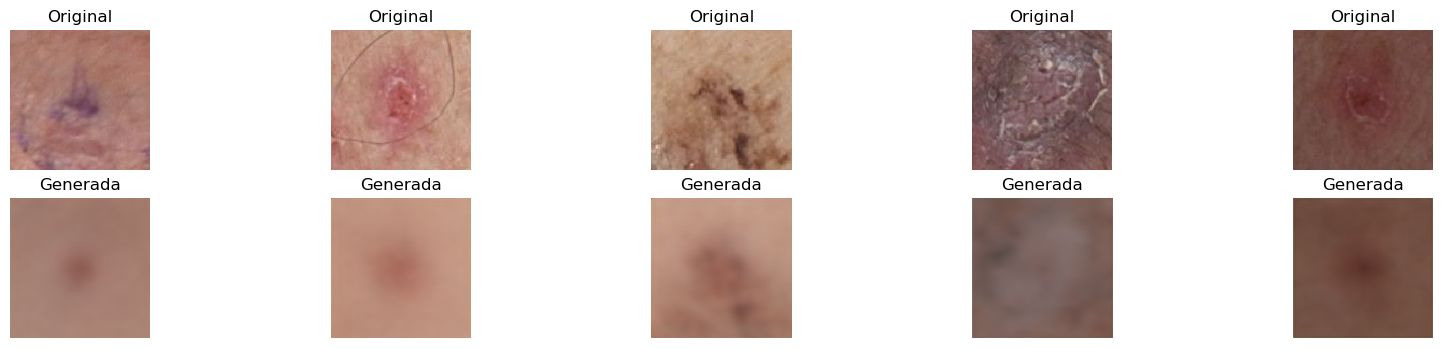

In [ ]:
n = 5
# Seleccionar aleatoriamente imágenes del conjunto de datos
indices = np.random.choice(len(X_minoritaria), n)
imgs_originales = X_minoritaria[indices]
imgs_generadas = vae.predict(imgs_originales)

# Crear un gráfico para comparar las imágenes originales con las generadas
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs_originales[i])
    plt.title("Original")
    plt.axis("off")
    
    # Imagen generada
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_generadas[i])
    plt.title("Generada")
    plt.axis("off")
plt.show()

I had studied before an AI architecture proposed by some excellent authors which main objective is to generate minority class images. So lets use that knowledge to try to tackle the class imbalance issue.
Improved Balancing GAN: Minority-class Image Generation
 - Gaofeng Huang - Amir Hossein Jafari

In [5]:
# Crear una nueva columna 'image_name' que combine 'isic_id' con la extensión '.jpg'
data['image_name'] = data['isic_id'] + '.jpg'

# Seleccionar solo las columnas 'image_name' y 'target'
data_output = data[['image_name', 'target']]

# Guardar en archivo de texto, separado por tabulaciones
data_output.to_csv('val.txt', sep='\t', index=False, header=False)

In [3]:
import os
import numpy as np
import random

def create_subset(label_file, output_file, total_images=3000):
    # Leer el archivo de etiquetas
    with open(label_file, 'r') as f:
        list_images = f.readlines()

    # Separar imágenes por clase
    class_1_images = [line for line in list_images if int(line.split()[1]) == 1]
    class_0_images = [line for line in list_images if int(line.split()[1]) == 0]

    # Verificar si hay suficientes imágenes de clase 0 para completar
    if len(class_1_images) > total_images:
        raise ValueError(f"El número de imágenes con clase 1 ({len(class_1_images)}) excede el total deseado ({total_images}).")
    
    if len(class_0_images) < (total_images - len(class_1_images)):
        raise ValueError("No hay suficientes imágenes de clase 0 para completar el subconjunto.")

    # Seleccionar aleatoriamente imágenes de clase 0 para completar el total
    selected_class_0_images = random.sample(class_0_images, total_images - len(class_1_images))

    # Crear el subconjunto
    subset_images = class_1_images + selected_class_0_images

    # Escribir el subconjunto en el archivo de salida
    with open(output_file, 'w') as f:
        for line in subset_images:
            f.write(line)

    print(f"Subconjunto creado con éxito y guardado en {output_file}. Total de imágenes: {len(subset_images)}.")

# Ejecución del código
label_file = 'val.txt'  # Archivo original de etiquetas
output_file = 'subset2.txt'  # Archivo de salida para el subconjunto

create_subset(label_file, output_file, total_images=3000)


Subconjunto creado con éxito y guardado en subset2.txt. Total de imágenes: 3000.


In [1]:
import os
import shutil

# Define los caminos de las carpetas y archivo
ruta_imagenes = r"E:\Descargas\isic-2024-challenge\train-image\image"  # Carpeta donde están las imágenes originales
ruta_subset = 'subset2.txt'     # Archivo de texto con los nombres de las imágenes
ruta_destino = r"C:\Users\Miguel Palomino\Repository\ISIC-CHALLENGE-2024\BAGANGP\dataset"         # Carpeta donde se copiarán las imágenes

# Crea la carpeta de destino si no existe
os.makedirs(ruta_destino, exist_ok=True)

# Lee los nombres de las imágenes del archivo subset.txt
nombres_imagenes = []
with open(ruta_subset, 'r') as archivo:
    for linea in archivo:
        # Divide la línea en nombre de archivo y etiqueta
        partes = linea.split('\t')
        if len(partes) > 1:
            nombre_imagen = partes[0].strip()
            nombres_imagenes.append(nombre_imagen)

# Copia las imágenes listadas en subset.txt a la carpeta de destino
for nombre_imagen in nombres_imagenes:
    origen = os.path.join(ruta_imagenes, nombre_imagen)
    destino = os.path.join(ruta_destino, nombre_imagen)
    
    # Verifica si el archivo existe antes de copiar
    if os.path.isfile(origen):
        shutil.copy(origen, destino)
        print(f'Imagen copiada: {nombre_imagen}')
    else:
        print(f'Imagen no encontrada: {nombre_imagen}')

print('Proceso completado.')

with open('labels.txt', 'w') as salida:
    for archivo in ['subset2.txt', 'image_labels.txt']:
        with open(archivo, 'r') as entrada:
            salida.write(entrada.read())


Imagen copiada: ISIC_0082829.jpg
Imagen copiada: ISIC_0096034.jpg
Imagen copiada: ISIC_0104229.jpg
Imagen copiada: ISIC_0119495.jpg
Imagen copiada: ISIC_0157834.jpg
Imagen copiada: ISIC_0190307.jpg
Imagen copiada: ISIC_0211092.jpg
Imagen copiada: ISIC_0220459.jpg
Imagen copiada: ISIC_0238218.jpg
Imagen copiada: ISIC_0275647.jpg
Imagen copiada: ISIC_0279372.jpg
Imagen copiada: ISIC_0287900.jpg
Imagen copiada: ISIC_0293670.jpg
Imagen copiada: ISIC_0321944.jpg
Imagen copiada: ISIC_0330452.jpg
Imagen copiada: ISIC_0332355.jpg
Imagen copiada: ISIC_0338720.jpg
Imagen copiada: ISIC_0386460.jpg
Imagen copiada: ISIC_0392749.jpg
Imagen copiada: ISIC_0429895.jpg
Imagen copiada: ISIC_0445144.jpg
Imagen copiada: ISIC_0452332.jpg
Imagen copiada: ISIC_0467830.jpg
Imagen copiada: ISIC_0521019.jpg
Imagen copiada: ISIC_0527743.jpg
Imagen copiada: ISIC_0528190.jpg
Imagen copiada: ISIC_0554252.jpg
Imagen copiada: ISIC_0565021.jpg
Imagen copiada: ISIC_0638180.jpg
Imagen copiada: ISIC_0664135.jpg
Imagen cop

In [2]:
import os
import shutil

# Ruta del archivo de texto
ruta_archivo = 'labels.txt'

# Leer el archivo y reemplazar espacios por tabulaciones
with open(ruta_archivo, 'r') as archivo:
    contenido = archivo.read()

# Reemplazar los espacios simples por tabulaciones
contenido_modificado = contenido.replace(' ', '\t')

# Guardar el archivo modificado
with open(ruta_archivo, 'w') as archivo:
    archivo.write(contenido_modificado)

print("Reemplazo completado.")


Reemplazo completado.


In [8]:
import os
import shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Leer el archivo de etiquetas
ruta_labels = 'labels.txt'
ruta_imagenes = r'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset'

# Cargar el archivo de etiquetas
labels_df = pd.read_csv(ruta_labels, sep='\t', header=None, names=['imagen', 'clase'])

# Separar nombres de imágenes y etiquetas
imagenes = labels_df['imagen'].values
etiquetas = labels_df['clase'].values

# Dividir en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
x_train, x_test, y_train, y_test = train_test_split(imagenes, etiquetas, test_size=0.2, stratify=etiquetas, shuffle=True, random_state=42)


In [9]:
imagenes_clase_1 = [img for img, clase in zip(x_train, y_train) if clase == 1]
imagenes_clase_0 = [img for img, clase in zip(x_train, y_train) if clase == 0]

In [10]:
print(np.shape(imagenes_clase_1))
print(np.shape(imagenes_clase_0))

(560,)
(2085,)


In [25]:
len(imagenes_clase_1)

560

In [11]:
x_train

array(['ISIC_3951022.jpg', 'ISIC_1357366.jpg', 'ISIC_4617550.jpg', ...,
       'ISIC_1998614.jpg', 'ISIC_1846409.jpg', 'ISIC_3084319.jpg'],
      dtype=object)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import os

def augmentar_clase1(x_train, y_train, ruta_imagenes, num_aumentos=5):
    # Filtrar imágenes de la clase 1
    imagenes_clase1 = [img for img, clase in zip(x_train, y_train) if clase == 1]
    
    # Configurar el generador de data augmentation
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.8, 1.2),
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Crear carpeta para guardar imágenes aumentadas si no existe
    ruta_aumentadas = os.path.join(ruta_imagenes, 'augmentadas_clase1')
    os.makedirs(ruta_aumentadas, exist_ok=True)
    
    for img_name in imagenes_clase1:
        img_path = os.path.join(ruta_imagenes, img_name)
        img = load_img(img_path)  # Cargar imagen
        img_array = img_to_array(img)  # Convertir imagen a array
        img_array = np.expand_dims(img_array, axis=0)  # Expandir dimensiones
        
        # Generar y guardar imágenes aumentadas
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=ruta_aumentadas,
                                  save_prefix='aug', save_format='jpg'):
            i += 1
            if i >= num_aumentos:
                break

    print(f"Se han generado {num_aumentos * len(imagenes_clase1)} imágenes aumentadas en '{ruta_aumentadas}'.")

# Ejemplo de uso
augmentar_clase1(x_train, y_train, ruta_imagenes, num_aumentos=5)


Se han generado 2800 imágenes aumentadas en 'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\augmentadas_clase1'.


In [13]:
import os
import shutil

def mover_imagenes_a_test(x_test, y_test, ruta_imagenes, ruta_destino):
    # Crear la carpeta de test si no existe
    os.makedirs(ruta_destino, exist_ok=True)
    
    # Crear y abrir el archivo de texto para escribir las etiquetas
    ruta_labels_test = os.path.join(ruta_destino, 'labels_test.txt')
    with open(ruta_labels_test, 'w') as f:
        for img_name, clase in zip(x_test, y_test):
            img_path = os.path.join(ruta_imagenes, img_name)
            if os.path.exists(img_path):
                # Mover la imagen a la carpeta de test
                shutil.move(img_path, os.path.join(ruta_destino, img_name))
                # Escribir el nombre de la imagen y su clase en el archivo de texto
                f.write(f"{img_name}\t{clase}\n")
            else:
                print(f"Advertencia: La imagen {img_path} no existe y no se pudo mover.")

    print(f"Imágenes movidas a '{ruta_destino}' y etiquetas guardadas en '{ruta_labels_test}'.")

# Definir la ruta destino para la carpeta de test
ruta_destino_test = os.path.join(ruta_imagenes, 'test')

# Ejecutar la función para mover imágenes y generar el archivo de etiquetas
mover_imagenes_a_test(x_test, y_test, ruta_imagenes, ruta_destino_test)


Imágenes movidas a 'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\test' y etiquetas guardadas en 'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\test\labels_test.txt'.


In [15]:
def reemplazar_espacios_por_tabulaciones(ruta_archivo):
    # Leer el archivo y reemplazar los espacios por tabulaciones
    with open(ruta_archivo, 'r') as file:
        contenido = file.read()

    # Reemplazar todos los espacios con tabulaciones
    contenido_modificado = contenido.replace(' ', '\t')

    # Escribir el contenido modificado de nuevo en el archivo
    with open(ruta_archivo, 'w') as file:
        file.write(contenido_modificado)

    print(f"Espacios en '{ruta_archivo}' han sido reemplazados por tabulaciones.")

# Ruta del archivo que deseas modificar
ruta_labels_test = os.path.join(ruta_destino_test, 'labels_test.txt')

# Llamar a la función para reemplazar espacios por tabulaciones
reemplazar_espacios_por_tabulaciones(ruta_labels_test)

Espacios en 'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\test\labels_test.txt' han sido reemplazados por tabulaciones.


In [18]:
f=pd.read_csv(r'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\test\labels_test.txt', sep='\t', header=None, names=['imagen', 'clase'])

In [19]:
f.head()

,imagen,clase
0,ISIC_7104772.jpg,0
1,176.jpg,1
2,ISIC_4416759.jpg,1
3,ISIC_6996014.jpg,0
4,ISIC_6898851.jpg,0


In [20]:
import os
import shutil

def mover_imagenes_a_train(x_train, y_train, ruta_imagenes, ruta_aumentadas, ruta_destino):
    # Crear la carpeta de train si no existe
    os.makedirs(ruta_destino, exist_ok=True)
    
    # Crear y abrir el archivo de texto para escribir las etiquetas
    ruta_labels_train = os.path.join(ruta_destino, 'labels_train.txt')
    with open(ruta_labels_train, 'w') as f:
        for img_name, clase in zip(x_train, y_train):
            # Verificar si la imagen es original o aumentada
            if 'augmentadas_clase1' in img_name:
                img_path = os.path.join(ruta_aumentadas, os.path.basename(img_name))
            else:
                img_path = os.path.join(ruta_imagenes, img_name)
            
            if os.path.exists(img_path):
                # Mover la imagen a la carpeta de train
                shutil.move(img_path, os.path.join(ruta_destino, os.path.basename(img_name)))
                # Escribir el nombre de la imagen y su clase en el archivo de texto
                f.write(f"{os.path.basename(img_name)}\t{clase}\n")
            else:
                print(f"Advertencia: La imagen {img_path} no existe y no se pudo mover.")

    print(f"Imágenes movidas a '{ruta_destino}' y etiquetas guardadas en '{ruta_labels_train}'.")

# Definir la ruta destino para la carpeta de train
ruta_destino_train = os.path.join(ruta_imagenes, 'train')

# Ejecutar la función para mover imágenes y generar el archivo de etiquetas
mover_imagenes_a_train(x_train, y_train, ruta_imagenes, os.path.join(ruta_imagenes, 'augmentadas_clase1'), ruta_destino_train)

# Reemplazar espacios por tabulaciones en el archivo labels_train.txt
reemplazar_espacios_por_tabulaciones(os.path.join(ruta_destino_train, 'labels_train.txt'))


Imágenes movidas a 'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\train' y etiquetas guardadas en 'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\train\labels_train.txt'.
Espacios en 'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\train\labels_train.txt' han sido reemplazados por tabulaciones.


In [21]:
import os
import shutil

def mover_aumentadas_a_train(ruta_aumentadas, ruta_destino_train, ruta_labels_train):
    # Mover imágenes de augmentadas_clase1 a la carpeta train
    for img_name in os.listdir(ruta_aumentadas):
        img_path = os.path.join(ruta_aumentadas, img_name)
        destino_path = os.path.join(ruta_destino_train, img_name)
        
        if os.path.exists(img_path):
            shutil.move(img_path, destino_path)
            # Adicionar el nombre de la imagen y la clase 1 al archivo labels_train.txt
            with open(ruta_labels_train, 'a') as f:
                f.write(f"{img_name}\t1\n")
        else:
            print(f"Advertencia: La imagen {img_path} no existe y no se pudo mover.")
    
    print(f"Imágenes aumentadas movidas a '{ruta_destino_train}' y etiquetas añadidas en '{ruta_labels_train}'.")

# Definir la ruta destino para la carpeta de train
ruta_destino_train = os.path.join(ruta_imagenes, 'train')
# Definir la ruta de la carpeta augmentadas_clase1
ruta_aumentadas = os.path.join(ruta_imagenes, 'augmentadas_clase1')
# Definir la ruta del archivo labels_train.txt
ruta_labels_train = os.path.join(ruta_destino_train, 'labels_train.txt')

# Crear la carpeta de train si no existe
os.makedirs(ruta_destino_train, exist_ok=True)

# Mover las imágenes de augmentadas_clase1 a la carpeta train y actualizar labels_train.txt
mover_aumentadas_a_train(ruta_aumentadas, ruta_destino_train, ruta_labels_train)


Imágenes aumentadas movidas a 'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\train' y etiquetas añadidas en 'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\train\labels_train.txt'.


In [28]:
ff=pd.read_csv(r'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\train\labels_train.txt', sep='\t', header=None, names=['imagen', 'clase'])

In [29]:
ff.head()

,imagen,clase
0,ISIC_3951022.jpg,1
1,ISIC_1357366.jpg,1
2,ISIC_4617550.jpg,0
3,ISIC_2457317.jpg,0
4,ISIC_0293670.jpg,1


In [30]:
conteo_por_clase = ff['clase'].value_counts()

# Mostrar el conteo
print(conteo_por_clase)

clase
1    3005
0    3005
Name: count, dtype: int64


In [32]:
ruta_labels_train = r'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\train\labels_train.txt'
ruta_imagenes_train = r'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\train'

# Leer nombres de imágenes del archivo de texto
with open(ruta_labels_train, 'r') as file:
    nombres_archivo = set(line.split('\t')[0] for line in file)

# Obtener nombres de las imágenes en la carpeta
nombres_carpeta = set(os.path.splitext(img)[0] for img in os.listdir(ruta_imagenes_train))
nombres_carpeta = set(os.path.splitext(img)[0] + '.jpg' for img in nombres_carpeta)
# Comparar
nombres_faltantes = nombres_archivo - nombres_carpeta
nombres_excedentes = nombres_carpeta - nombres_archivo

# Mostrar resultados
print(f"Nombres en el archivo de texto pero no en la carpeta ({len(nombres_faltantes)}):")
print(nombres_faltantes)

print(f"\nNombres en la carpeta pero no en el archivo de texto ({len(nombres_excedentes)}):")
print(nombres_excedentes)

Nombres en el archivo de texto pero no en la carpeta (920):
{'ISIC_0083141', 'ISIC_0079597', 'ISIC_0077158', 'ISIC_0077392', 'ISIC_0092194', 'ISIC_0074298', 'ISIC_0091709', 'ISIC_0078547', 'ISIC_0073665', 'ISIC_0079204', 'ISIC_0089799', 'ISIC_0082607', 'ISIC_0089053', 'ISIC_0076429', 'ISIC_0091705', 'ISIC_0084322', 'ISIC_0095327', 'ISIC_0080032', 'ISIC_0092930', 'ISIC_0087260', 'ISIC_0090351', 'ISIC_0084852', 'ISIC_0085656', 'ISIC_0093587', 'ISIC_0084190', 'ISIC_0093556', 'ISIC_0087993', 'ISIC_0082596', 'ISIC_0087476', 'ISIC_0086083', 'ISIC_0094234', 'ISIC_0094051', 'ISIC_0052004', 'ISIC_0083759', 'ISIC_0090298', 'ISIC_0024200', 'ISIC_0089368', 'ISIC_0092150', 'ISIC_0077707', 'ISIC_0078045', 'ISIC_0078776', 'ISIC_0083721', 'ISIC_0080416', 'ISIC_0085253', 'ISIC_0077349', 'ISIC_0086799', 'ISIC_0086924', 'ISIC_0083711', 'ISIC_0078537', 'ISIC_0076432', 'ISIC_0080418', 'ISIC_0079627', 'ISIC_0080458', 'ISIC_0091366', 'ISIC_0084768', 'ISIC_0091884', 'ISIC_0073396', 'ISIC_0076681', 'ISIC_00740

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Definimos las rutas
train_dir = r'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\train'
test_dir = r'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\test'
train_labels_path = os.path.join(train_dir, 'labels_train.txt')
test_labels_path = os.path.join(test_dir, 'labels_test.txt')

# Función para cargar etiquetas desde un archivo de texto
def load_labels(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None, names=['filename', 'class'])
    return df

train_df = load_labels(train_labels_path)
test_df = load_labels(test_labels_path)

# Convertir las clases a enteros si es necesario
train_df['class'] = train_df['class'].astype(int)
test_df['class'] = test_df['class'].astype(int)

# Verificar las primeras filas para asegurar que todo está correcto
print(train_df.head())
print(test_df.head())


           filename  class
0  ISIC_3951022.jpg      1
1  ISIC_1357366.jpg      1
2  ISIC_4617550.jpg      0
3  ISIC_2457317.jpg      0
4  ISIC_0293670.jpg      1
           filename  class
0  ISIC_7104772.jpg      0
1           176.jpg      1
2  ISIC_4416759.jpg      1
3  ISIC_6996014.jpg      0
4  ISIC_6898851.jpg      0


In [4]:
train_df['class'] = train_df['class'].astype(str)
test_df['class'] = test_df['class'].astype(str)

In [5]:
# Corregir los nombres de archivo sin extensión
train_df.loc[train_df['filename'].str.endswith(tuple(['.jpg', '.png', '.jpeg'])) == False, 'filename'] += '.jpg'

# Verificar si la corrección se realizó correctamente
print(train_df.tail(10))


              filename class
6000  ISIC_0095543.jpg     0
6001  ISIC_0095615.jpg     0
6002  ISIC_0095623.jpg     0
6003  ISIC_0095626.jpg     0
6004  ISIC_0095627.jpg     0
6005  ISIC_0095630.jpg     0
6006  ISIC_0095642.jpg     0
6007  ISIC_0095662.jpg     0
6008  ISIC_0095685.jpg     0
6009  ISIC_0095689.jpg     0


In [6]:
conteo_por_clase = train_df['class'].value_counts()

# Mostrar el conteo
print(conteo_por_clase)

class
1    3005
0    3005
Name: count, dtype: int64


In [7]:
# Definimos el tamaño de las imágenes y otras variables
img_height, img_width = 224, 224
batch_size = 64

# Definimos el ImageDataGenerator para entrenamiento y validación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Creamos los generadores a partir de los DataFrames
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Es importante no mezclar para la evaluación
)


Found 6010 validated image filenames belonging to 2 classes.
Found 662 validated image filenames belonging to 2 classes.


In [48]:
import os

# Lista de nombres de imágenes en el archivo de texto
image_names_from_file = set(train_df['filename'])

# Lista de nombres de archivos realmente en el directorio
image_names_in_directory = set(os.listdir(train_dir))

# Encontrar los nombres de imágenes que faltan en el directorio
missing_images = image_names_from_file - image_names_in_directory

print(f"Imágenes faltantes: {missing_images}")
print(f"Número de imágenes faltantes: {len(missing_images)}")


Imágenes faltantes: set()
Número de imágenes faltantes: 0


In [17]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.03))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

# Modelo InceptionV3

base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model_inception.trainable = False
model_inception = build_model(base_model_inception)

In [18]:
model_inception.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [19]:
epochs = 50
#checkpoint para guardar mejores pesos
checkpoint = ModelCheckpoint(
    'icv3_best_loss3.h5',  # The path where to save the model
    monitor='val_loss',       # Metrica
    verbose=1,
    save_best_only=True,      # Solo guarda si `val_loss` mejora
    save_weights_only=True,   # Solo pesos
    mode='min',               # Minimizar
    save_freq='epoch'         # Comprobar metrica cada epoca
)

#Early stopping que parara training si val_loss no mejora luego de 2 epocas
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min', min_lr=1e-6)
# Entrenamiento del modelo InceptionV3
history_inception = model_inception.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[checkpoint,early_stopping,reduce_lr]
)

Epoch 1/50
93/93 [==============================] - ETA: 0s - loss: 43.9836 - accuracy: 0.7534
Epoch 1: val_loss improved from inf to 33.89621, saving model to icv3_best_loss3.h5
93/93 [==============================] - 44s 431ms/step - loss: 43.9836 - accuracy: 0.7534 - val_loss: 33.8962 - val_accuracy: 0.8375 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - ETA: 0s - loss: 26.6818 - accuracy: 0.8338
Epoch 2: val_loss improved from 33.89621 to 20.44890, saving model to icv3_best_loss3.h5
93/93 [==============================] - 40s 434ms/step - loss: 26.6818 - accuracy: 0.8338 - val_loss: 20.4489 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - ETA: 0s - loss: 16.0257 - accuracy: 0.8481
Epoch 3: val_loss improved from 20.44890 to 12.33568, saving model to icv3_best_loss3.h5
93/93 [==============================] - 40s 426ms/step - loss: 16.0257 - accuracy: 0.8481 - val_loss: 12.3357 - val_accuracy: 0.8109 - lr: 1.0000e-04


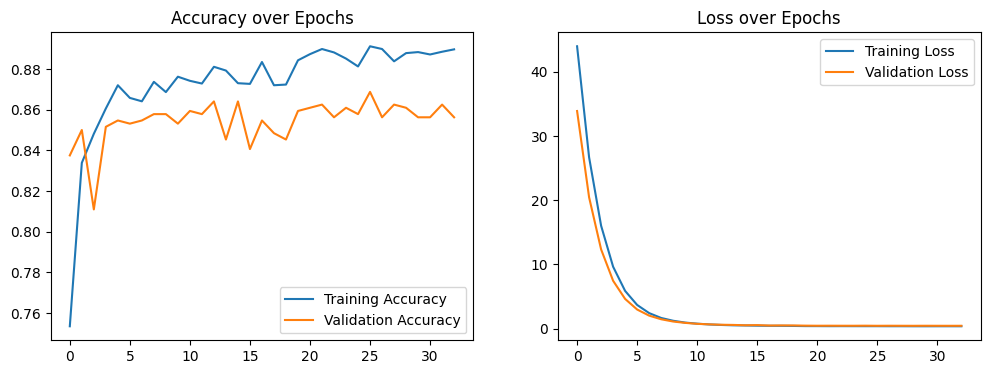

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

In [21]:
# Evaluación InceptionV3
inception_loss, inception_acc = model_inception.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"InceptionV3 - Loss: {inception_loss}, Accuracy: {inception_acc}")

# Evaluación VGG16
#vgg_loss, vgg_acc = model_vgg.evaluate(test_generator, steps=test_generator.samples // batch_size)
#print(f"VGG16 - Loss: {vgg_loss}, Accuracy: {vgg_acc}")

# Predicciones
inception_preds = model_inception.predict(test_generator, steps=test_generator.samples // batch_size)
inception_preds = np.round(inception_preds).astype(int).flatten()

#vgg_preds = model_vgg.predict(test_generator, steps=test_generator.samples // batch_size)
#vgg_preds = np.round(vgg_preds).astype(int).flatten()

# Obtención de las etiquetas verdaderas
true_labels = test_generator.classes[:len(inception_preds)]

# Reportes de clasificación
print("InceptionV3 Classification Report")
print(classification_report(true_labels, inception_preds))

#print("VGG16 Classification Report")
#print(classification_report(true_labels, vgg_preds))


10/10 [==============================] - 1s 91ms/step - loss: 0.4274 - accuracy: 0.8609
InceptionV3 - Loss: 0.4273630678653717, Accuracy: 0.8609374761581421
10/10 [==============================] - 2s 84ms/step
InceptionV3 Classification Report
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       502
           1       0.71      0.59      0.65       138

    accuracy                           0.86       640
   macro avg       0.80      0.76      0.78       640
weighted avg       0.85      0.86      0.86       640



In [31]:
# Guardar el modelo completo en un archivo .h5
model_inception.save('icv3_loss3_comp2.h5', save_format='tf')


In [23]:
image_ids = test_generator.filenames[:len(inception_preds)]

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc

class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC
    
    Given a solution file and submission file, this function returns the
    partial area under the receiver operating characteristic (pAUC) 
    above a given true positive rate (TPR) = 0.80.
    
    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # Check submission is numeric
    if not pd.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    # Rescale the target. Set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values) - 1)
    
    # Flip the submissions to their compliments
    v_pred = -1.0 * np.asarray(submission.values)

    max_fpr = abs(1 - min_tpr)

    # Using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return partial_auc

# Ejemplo de uso después de entrenar el modelo

# Asumiendo que tienes las siguientes variables después de entrenar tu modelo
# y_true: las etiquetas verdaderas del conjunto de validación o prueba (ground truth)
# y_pred: las probabilidades predichas por el modelo para la clase positiva

# Crear DataFrames para las soluciones y predicciones
solution_df = pd.DataFrame({'id': image_ids, 'label': true_labels})
submission_df = pd.DataFrame({'id': image_ids, 'label': inception_preds})

# Calcular pAUC
pauc_score = score(solution_df, submission_df, row_id_column_name='id', min_tpr=0.80)
print(f'pAUC score: {pauc_score:.4f}')


pAUC score: 0.0460


In [29]:
inception_probs = model_inception.predict(test_generator, steps=test_generator.samples // batch_size).flatten()
inception_probs = np.round(inception_probs, 2)
isic_ids = [fname.split('/')[-1].split('.')[0] for fname in test_generator.filenames[:len(inception_probs)]]

# Crear un DataFrame con los isic_ids y las probabilidades predichas
submission_df = pd.DataFrame({
    'isic_id': isic_ids,
    'target': inception_probs
})

# Guardar el DataFrame en un archivo CSV con el formato requerido
submission_df.to_csv('submission.csv', index=False)

print("Archivo 'submission.csv' generado exitosamente.")

10/10 [==============================] - 1s 122ms/step
Archivo 'submission.csv' generado exitosamente.


In [59]:

epochs = 25
#checkpoint para guardar mejores pesos
checkpoint = ModelCheckpoint(
    'vgg16_best.h5',  # The path where to save the model
    monitor='val_loss',       # Metrica
    verbose=1,
    save_best_only=True,      # Solo guarda si `val_loss` mejora
    save_weights_only=True,   # Solo pesos
    mode='min',               # Minimizar
    save_freq='epoch'         # Comprobar metrica cada epoca
)

#Early stopping que parara training si val_loss no mejora luego de 2 epocas
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
model_vgg = build_model(base_model_vgg)

model_vgg.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

history_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)


Epoch 1/25
93/93 [==============================] - ETA: 0s - loss: 0.6352 - accuracy: 0.6850
Epoch 1: val_loss improved from inf to 0.58679, saving model to vgg16_best.h5
93/93 [==============================] - 16s 168ms/step - loss: 0.6352 - accuracy: 0.6850 - val_loss: 0.5868 - val_accuracy: 0.7281 - lr: 1.0000e-04
Epoch 2/25
93/93 [==============================] - ETA: 0s - loss: 0.5543 - accuracy: 0.7524
Epoch 2: val_loss improved from 0.58679 to 0.57802, saving model to vgg16_best.h5
93/93 [==============================] - 15s 165ms/step - loss: 0.5543 - accuracy: 0.7524 - val_loss: 0.5780 - val_accuracy: 0.7125 - lr: 1.0000e-04
Epoch 3/25
93/93 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.7765
Epoch 3: val_loss did not improve from 0.57802
93/93 [==============================] - 15s 159ms/step - loss: 0.5065 - accuracy: 0.7765 - val_loss: 0.6042 - val_accuracy: 0.6922 - lr: 1.0000e-04
Epoch 4/25
93/93 [==============================] - ETA: 0s - lo

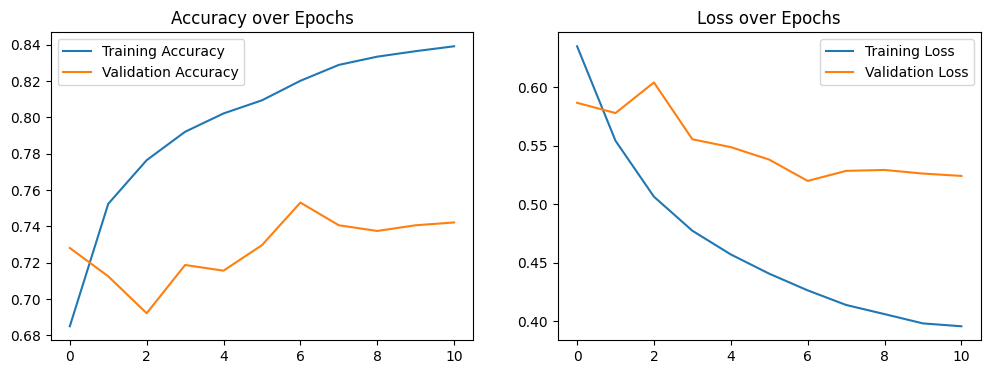

In [61]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

In [ ]:
model_vgg.fit(train_generator(), steps_per_epoch=steps_per_epoch, epochs=10,
              validation_data=test_generator(), validation_steps=validation_steps)

In [27]:
import os
import shutil
import pandas as pd

# Leer el archivo CSV con metadata
data = pd.read_csv(r'E:\Descargas\isic-2024-challenge\train-metadata.csv')

# Filtrar imágenes de la clase 0
imagenes_clase_0 = data[data['target'] == 0]['isic_id']

# Leer los dataframes f y ff
# f = pd.read_csv('ruta_al_archivo_f.csv')  # Si f y ff están en archivos CSV
# ff = pd.read_csv('ruta_al_archivo_ff.csv')

# Extraer los nombres de las imágenes en f y ff
imagenes_f = f['imagen'].tolist()
imagenes_ff = ff['imagen'].tolist()

# Combinar listas de imágenes a excluir
imagenes_excluidas = set(imagenes_f + imagenes_ff)

# Filtrar imágenes que no están en f y ff
imagenes_para_copiar = [img for img in imagenes_clase_0 if img not in imagenes_excluidas]

# Seleccionar las primeras 920 imágenes
imagenes_seleccionadas = imagenes_para_copiar[:920]

# Definir rutas de origen y destino
ruta_origen = r'E:\Descargas\isic-2024-challenge\train-image\image'
ruta_destino = r'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\train'
ruta_labels_train = os.path.join(ruta_destino, 'labels_train.txt')

# Crear la carpeta de destino si no existe
os.makedirs(ruta_destino, exist_ok=True)

# Abrir el archivo de etiquetas en modo de adición
with open(ruta_labels_train, 'a') as labels_file:
    for img_name in imagenes_seleccionadas:
        origen_path = os.path.join(ruta_origen, img_name + '.jpg')  # Asumiendo que las imágenes tienen extensión .jpg
        destino_path = os.path.join(ruta_destino, img_name + '.jpg')
        
        if os.path.exists(origen_path):
            shutil.copy(origen_path, destino_path)
            # Añadir el nombre de la imagen y su clase al archivo labels_train.txt
            labels_file.write(f"{img_name}\t0\n")
        else:
            print(f"Advertencia: La imagen {origen_path} no existe y no se pudo copiar.")

print(f"Se han copiado {len(imagenes_seleccionadas)} imágenes de la clase 0 al directorio '{ruta_destino}' y se han registrado en '{ruta_labels_train}'.")


C:\Users\Miguel Palomino\AppData\Local\Temp\ipykernel_16088\3132326293.py:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r'E:\Descargas\isic-2024-challenge\train-metadata.csv')


Se han copiado 920 imágenes de la clase 0 al directorio 'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\train' y se han registrado en 'C:\Users\Miguel Palomino\Desktop\Ejerciciospy\BAGANGP\dataset\train\labels_train.txt'.
